In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
train_data = np.load('Available data/train_data.npy')
test_data = np.load('Available data/test_data.npy')
train_label = np.load('Available data/train_label.npy')
test_label = np.load('Available data/test_label.npy')

EEG_type = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# train_data_split = np.load('Available data/train_data_split.npy')
# test_data_split = np.load('Available data/test_data_split.npy')

train_data.shape, test_data.shape, train_label.shape, test_label.shape

((72360, 310), (49824, 310), (72360,), (49824,))

In [3]:
# Split and Standardize the original data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
train_data_scl = scaler.fit_transform(train_data)
test_data_scl = scaler.fit_transform(test_data)

In [4]:
train_data_ts = tf.constant(train_data_scl, dtype=tf.float16)
test_data_ts = tf.constant(test_data_scl, dtype=tf.float16)

train_data_ts.shape, test_data_ts.shape

2023-04-25 15:33:15.418053: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 15:33:16.356510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0


(TensorShape([72360, 310]), TensorShape([49824, 310]))

In [5]:
# Evaluatin gperformance function
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def Evaluate_performance(model, history, test_data=test_data_ts, test_label=test_label, display=True):
    
    # Prediction
    test_pred = np.argmax(model.predict(test_data), axis=1)
    
    # Performance
    print('Performance in tset dataset:')
    print(classification_report(test_label, test_pred))
    print('Accuracy: ', accuracy_score(test_label, test_pred))
    print('Confusion matrix:')
    print(confusion_matrix(test_label, test_pred))
    
    # Display learning curve
    key_names = list(history.history.keys())
    colors = ['-r','--b']

    plt.figure(figsize=(16, 5))
    for i in range(len(key_names)):
        plt.subplot(1,2,i+1)
        plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
        plt.legend(fontsize=15,ncol=2)
        plt.title('Learning Curves', size=15);

In [6]:
# Self design ANN
dnn_model1 = keras.models.Sequential([keras.layers.Input((310)),
                                      keras.layers.Dense(128, kernel_initializer='he_normal'),
                                      keras.layers.ReLU(),
                                      keras.layers.Dense(64, kernel_initializer='he_normal'),
                                      keras.layers.ReLU(),
                                      keras.layers.Dense(32, kernel_initializer='he_normal'),
                                      keras.layers.ReLU(),
                                      keras.layers.Dense(3, activation='softmax')])

dnn_model1.summary()                               

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               39808     
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 re_lu_2 (ReLU)              (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 9

In [7]:
# model compile and training
lr = 0.00001
optimizer = keras.optimizers.Nadam(learning_rate=lr)
loss = 'sparse_categorical_crossentropy'
epochs = 30
batch_size = 32

earlystop = keras.callbacks.EarlyStopping(monitor='loss', 
                                          patience=5)

dnn_model1.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=['accuracy'])

history = dnn_model1.fit(x=train_data_ts, y=train_label, epochs=epochs, batch_size=batch_size, callbacks=[earlystop])

Epoch 1/30
  80/2262 [>.............................] - ETA: 4s - loss: 1.5512 - accuracy: 0.3145 

2023-04-25 15:33:19.185953: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2262/2262 [==============================] - 6s 2ms/step - loss: 0.9283 - accuracy: 0.5766
Epoch 2/30
2262/2262 [==============================] - 4s 2ms/step - loss: 0.5701 - accuracy: 0.8145
Epoch 3/30
2262/2262 [==============================] - 4s 2ms/step - loss: 0.3799 - accuracy: 0.9004
Epoch 4/30
2262/2262 [==============================] - 4s 2ms/step - loss: 0.2475 - accuracy: 0.9539
Epoch 5/30
2262/2262 [==============================] - 4s 2ms/step - loss: 0.1580 - accuracy: 0.9790
Epoch 6/30
2262/2262 [==============================] - 4s 2ms/step - loss: 0.0990 - accuracy: 0.9911
Epoch 7/30
2262/2262 [==============================] - 4s 2ms/step - loss: 0.0620 - accuracy: 0.9963
Epoch 8/30
2262/2262 [==============================] - 4s 2ms/step - loss: 0.0392 - accuracy: 0.9982
Epoch 9/30
2262/2262 [==============================] - 4s 2ms/step - loss: 0.0247 - accuracy: 0.9993
Epoch 10/30
2262/2262 [==============================] - 4s 2ms/step - loss: 0.0154 - accurac

Performance in tset dataset:
              precision    recall  f1-score   support

         0.0       0.71      0.65      0.68     15804
         1.0       0.74      0.75      0.75     16920
         2.0       0.83      0.89      0.86     17100

    accuracy                           0.77     49824
   macro avg       0.76      0.76      0.76     49824
weighted avg       0.76      0.77      0.77     49824

Accuracy:  0.7674614643545279
Confusion matrix:
[[10321  3794  1689]
 [ 2810 12729  1381]
 [ 1306   606 15188]]


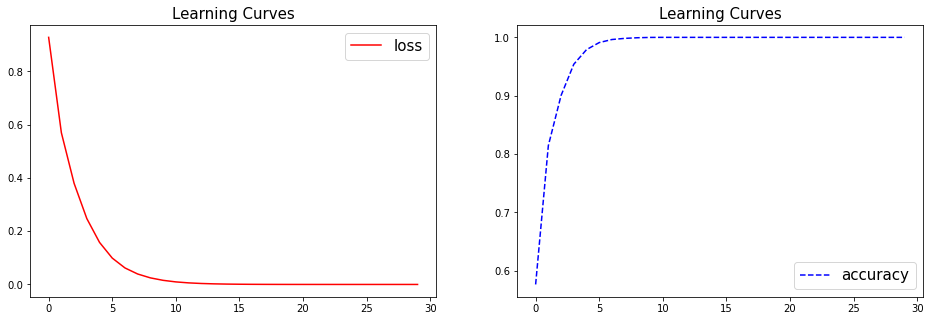

In [8]:
Evaluate_performance(model=dnn_model1, history=history, display=True)

In [10]:
# 1D CNN model
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense

dnn_model2 = keras.models.Sequential()

# Convolutional layers
dnn_model2.add(Conv1D(32, 3, activation='relu', input_shape=(310,1)))
dnn_model2.add(Conv1D(32, 3, activation='relu'))
dnn_model2.add(MaxPooling1D(3))
dnn_model2.add(Dropout(0.25))

dnn_model2.add(Conv1D(64, 3, activation='relu'))
dnn_model2.add(Conv1D(64, 3, activation='relu'))
dnn_model2.add(MaxPooling1D(3))
dnn_model2.add(Dropout(0.25))

# Global average pooling layer
dnn_model2.add(GlobalAveragePooling1D())

# Fully connected layers
dnn_model2.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
dnn_model2.add(Dropout(0.5))
dnn_model2.add(Dense(3, activation='softmax'))

dnn_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 308, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 306, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 102, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 102, 32)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 64)           6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 98, 64)            12352     
                                                      

In [11]:
# model compile and training
lr = 0.001
batch_size=32
epochs=50

optimizer = keras.optimizers.Nadam(learning_rate=lr)
dnn_model2.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

history = dnn_model2.fit(train_data_ts, train_label, batch_size=32, epochs=epochs, callbacks=[earlystop])

Epoch 1/50


2023-04-25 15:35:32.962496: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-04-25 15:35:34.401637: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-04-25 15:35:34.580024: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


2262/2262 [==============================] - 11s 3ms/step - loss: 0.9474 - accuracy: 0.4823
Epoch 2/50
2262/2262 [==============================] - 7s 3ms/step - loss: 0.6643 - accuracy: 0.6360
Epoch 3/50
2262/2262 [==============================] - 7s 3ms/step - loss: 0.5068 - accuracy: 0.7433
Epoch 4/50
2262/2262 [==============================] - 7s 3ms/step - loss: 0.3635 - accuracy: 0.8385
Epoch 5/50
2262/2262 [==============================] - 7s 3ms/step - loss: 0.2503 - accuracy: 0.9013
Epoch 6/50
2262/2262 [==============================] - 7s 3ms/step - loss: 0.1832 - accuracy: 0.9335
Epoch 7/50
2262/2262 [==============================] - 7s 3ms/step - loss: 0.1386 - accuracy: 0.9511
Epoch 8/50
2262/2262 [==============================] - 7s 3ms/step - loss: 0.1101 - accuracy: 0.9621
Epoch 9/50
2262/2262 [==============================] - 7s 3ms/step - loss: 0.0931 - accuracy: 0.9687
Epoch 10/50
2262/2262 [==============================] - 7s 3ms/step - loss: 0.0828 - accura

Performance in tset dataset:
              precision    recall  f1-score   support

         0.0       0.66      0.59      0.62     15804
         1.0       0.70      0.66      0.68     16920
         2.0       0.74      0.86      0.80     17100

    accuracy                           0.71     49824
   macro avg       0.70      0.70      0.70     49824
weighted avg       0.70      0.71      0.70     49824

Accuracy:  0.7065069043031471
Confusion matrix:
[[ 9336  3771  2697]
 [ 3373 11199  2348]
 [ 1373  1061 14666]]


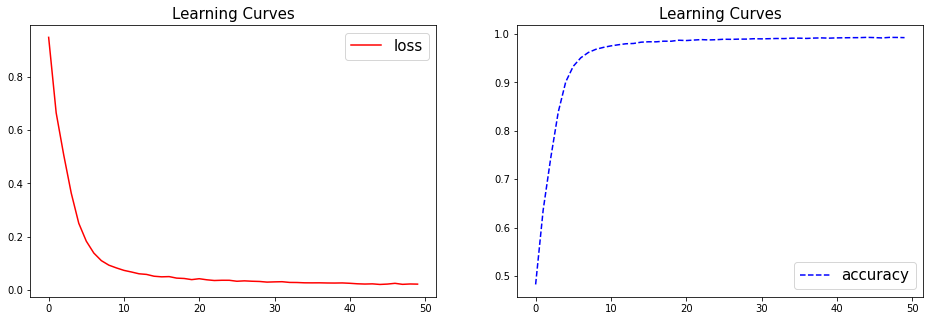

In [12]:
Evaluate_performance(model=dnn_model2, history=history, display=True)

In [13]:
# LSTM
from keras.layers import LSTM

dnn_model3 = keras.models.Sequential()

# LSTM layers
dnn_model3.add(LSTM(64, input_shape=(310, 1), return_sequences=True))
dnn_model3.add(Dropout(0.2))
dnn_model3.add(LSTM(64))
dnn_model3.add(Dropout(0.2))

# Fully connected layers
dnn_model3.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
dnn_model3.add(Dropout(0.5))
dnn_model3.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
dnn_model3.add(Dropout(0.5))

dnn_model3.add(Dense(3, activation='softmax'))

dnn_model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 310, 64)           16896     
                                                                 
 dropout_3 (Dropout)         (None, 310, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)               

In [14]:
# Compile the model and training
lr = 0.001
batch_size=32
epochs=50
optimizer = keras.optimizers.Nadam(learning_rate=lr)

dnn_model3.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = dnn_model3.fit(train_data_ts, train_label, batch_size=32, epochs=50, callbacks=[earlystop])

Epoch 1/50
2262/2262 [==============================] - 48s 20ms/step - loss: 0.8989 - accuracy: 0.5388
Epoch 2/50
2262/2262 [==============================] - 46s 20ms/step - loss: 0.6465 - accuracy: 0.6741
Epoch 3/50
2262/2262 [==============================] - 46s 20ms/step - loss: 0.4737 - accuracy: 0.8050
Epoch 4/50
2262/2262 [==============================] - 46s 20ms/step - loss: 0.3332 - accuracy: 0.8745
Epoch 5/50
2262/2262 [==============================] - 46s 20ms/step - loss: 0.2413 - accuracy: 0.9136
Epoch 6/50
2262/2262 [==============================] - 46s 20ms/step - loss: 0.1693 - accuracy: 0.9453
Epoch 7/50
2262/2262 [==============================] - 46s 20ms/step - loss: 0.1523 - accuracy: 0.9542
Epoch 8/50
2262/2262 [==============================] - 46s 20ms/step - loss: 0.1048 - accuracy: 0.9714
Epoch 9/50
2262/2262 [==============================] - 45s 20ms/step - loss: 0.0881 - accuracy: 0.9776
Epoch 10/50
2262/2262 [==============================] - 46s 20m

Performance in tset dataset:
              precision    recall  f1-score   support

         0.0       0.51      0.46      0.48     15804
         1.0       0.62      0.57      0.59     16920
         2.0       0.74      0.87      0.80     17100

    accuracy                           0.64     49824
   macro avg       0.62      0.63      0.63     49824
weighted avg       0.63      0.64      0.63     49824

Accuracy:  0.6378050738599872
Confusion matrix:
[[ 7216  5067  3521]
 [ 5600  9698  1622]
 [ 1252   984 14864]]


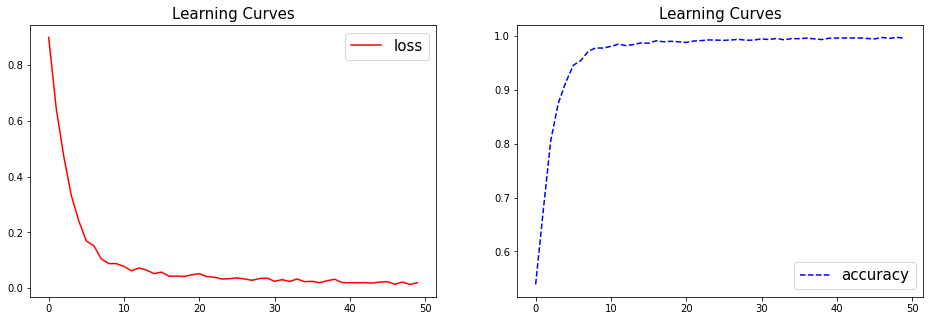

In [16]:
Evaluate_performance(model=dnn_model3, history=history, display=True)